In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=b7dfe656175685f483abaa80a8a4949d84d2df2bd57ec41599e72b6b6b1287ac
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
!unzip -q "/content/drive/MyDrive/code_files/Sri/Pyspark/Bike Sharing/archive (1).zip"

In [ ]:
# import pyspark libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, date_trunc, desc, asc, to_date
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import Window

from pyspark.ml.feature import OneHotEncoder, IndexToString, StringIndexer, Normalizer, StandardScaler, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import python libraries
import datetime as dt
import numpy as np
import pandas as pd

In [ ]:
# Importing and configuration of Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Bike Sharing with PySpark").getOrCreate()

In [ ]:
# As we have already learnt about reading a Dataframe in our previous notebooks so we would directly read our notebook now
data=spark.read.csv('/content/london_merged.csv',inferSchema=True,header=True)
# By default the show function will give us  20 rows but if need fewer rows then we can mention as a parameter inside the function.
data.show(5)

+-------------------+---+---+---+-----+----------+------------+----------+----------+------+
|          timestamp|cnt| t1| t2|  hum|wind_speed|weather_code|is_holiday|is_weekend|season|
+-------------------+---+---+---+-----+----------+------------+----------+----------+------+
|2015-01-04 00:00:00|182|3.0|2.0| 93.0|       6.0|         3.0|       0.0|       1.0|   3.0|
|2015-01-04 01:00:00|138|3.0|2.5| 93.0|       5.0|         1.0|       0.0|       1.0|   3.0|
|2015-01-04 02:00:00|134|2.5|2.5| 96.5|       0.0|         1.0|       0.0|       1.0|   3.0|
|2015-01-04 03:00:00| 72|2.0|2.0|100.0|       0.0|         1.0|       0.0|       1.0|   3.0|
|2015-01-04 04:00:00| 47|2.0|0.0| 93.0|       6.5|         1.0|       0.0|       1.0|   3.0|
+-------------------+---+---+---+-----+----------+------------+----------+----------+------+
only showing top 5 rows



In [ ]:
data.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- t1: double (nullable = true)
 |-- t2: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- weather_code: double (nullable = true)
 |-- is_holiday: double (nullable = true)
 |-- is_weekend: double (nullable = true)
 |-- season: double (nullable = true)



In [ ]:
print('Without any conversion: ',(data.count(), len(data.columns))) 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
pandasDF=data.toPandas()
print('By converting from spark to Pandas: ',pandasDF.shape)

Without any conversion:  (17414, 10)
By converting from spark to Pandas:  (17414, 10)


In [ ]:
data.columns

['timestamp',
 'cnt',
 't1',
 't2',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season']

In [ ]:
for i in data.columns:
  print("missing in",i,data.filter(data[i].isNull()).count())

missing in timestamp 0
missing in cnt 0
missing in t1 0
missing in t2 0
missing in hum 0
missing in wind_speed 0
missing in weather_code 0
missing in is_holiday 0
missing in is_weekend 0
missing in season 0


- We can observe that there are no values in the data

In [ ]:
data.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+
|summary|             count|                t1|               t2|               hum|        wind_speed|      weather_code|         is_holiday|         is_weekend|            season|               cnt|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+
|  count|             17414|             17414|            17414|             17414|             17414|             17414|              17414|              17414|             17414|             17414|
|   mean|1143.1016423567244|12.468090808162016|11.52083572604418| 72.32495405995176|15.913063244133076| 2.722751808889399|0.02205122315378431|0.28540254967267714|1.4920753416791088|1143.1016423567

In [ ]:
data=data.withColumnRenamed("cnt","count")
data.columns

['timestamp',
 'count',
 't1',
 't2',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season']

In [ ]:
data=data.withColumn('cnt',data['count'])

In [ ]:
data=data.drop('count')

In [ ]:
data.show(1)

+-------------------+---+---+----+----------+------------+----------+----------+------+---+
|          timestamp| t1| t2| hum|wind_speed|weather_code|is_holiday|is_weekend|season|cnt|
+-------------------+---+---+----+----------+------------+----------+----------+------+---+
|2015-01-04 00:00:00|3.0|2.0|93.0|       6.0|         3.0|       0.0|       1.0|   3.0|182|
+-------------------+---+---+----+----------+------------+----------+----------+------+---+
only showing top 1 row



In [ ]:
data.dtypes

[('timestamp', 'timestamp'),
 ('t1', 'double'),
 ('t2', 'double'),
 ('hum', 'double'),
 ('wind_speed', 'double'),
 ('weather_code', 'double'),
 ('is_holiday', 'double'),
 ('is_weekend', 'double'),
 ('season', 'double'),
 ('cnt', 'int')]

In [ ]:
from pyspark.sql.types import StringType
data = data.withColumn("is_holiday",data["is_holiday"].cast(StringType()))
data = data.withColumn("weather_code",data["weather_code"].cast(StringType()))
data = data.withColumn("is_weekend",data["is_weekend"].cast(StringType()))
data = data.withColumn("season",data["season"].cast(StringType()))

In [ ]:
data.dtypes

[('timestamp', 'timestamp'),
 ('t1', 'double'),
 ('t2', 'double'),
 ('hum', 'double'),
 ('wind_speed', 'double'),
 ('weather_code', 'string'),
 ('is_holiday', 'string'),
 ('is_weekend', 'string'),
 ('season', 'string'),
 ('cnt', 'int')]

In [ ]:
data.groupBy('is_holiday').count().show()

+----------+-----+
|is_holiday|count|
+----------+-----+
|       1.0|  384|
|       0.0|17030|
+----------+-----+



,t1,t2,hum,wind_speed,cnt
t1,1.000000,0.988344,-0.447781,0.145471,0.388798
t2,0.988344,1.000000,-0.403495,0.088409,0.369035
hum,-0.447781,-0.403495,1.000000,-0.287789,-0.462901
wind_speed,0.145471,0.088409,-0.287789,1.000000,0.116295
cnt,0.388798,0.369035,-0.462901,0.116295,1.000000


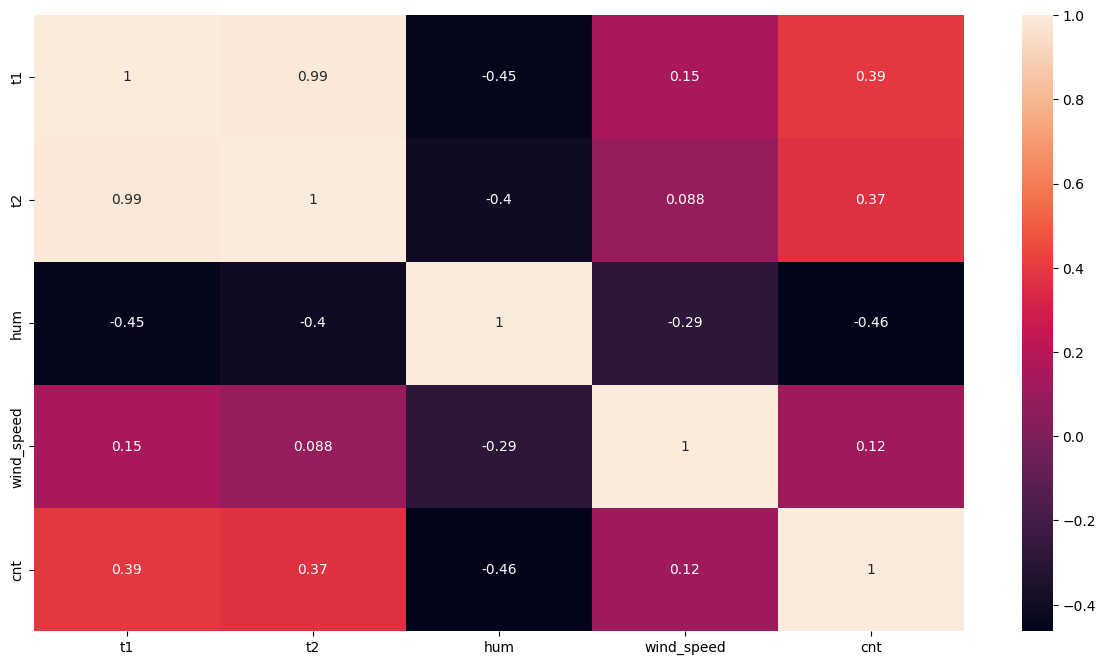

In [ ]:
# we will get it into pandas dataframe and perform the correlation analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pdf = data.toPandas()
corr = pdf.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True)
corr

In [ ]:
# code to ignore warnings
import warnings
warnings.filterwarnings("ignore")

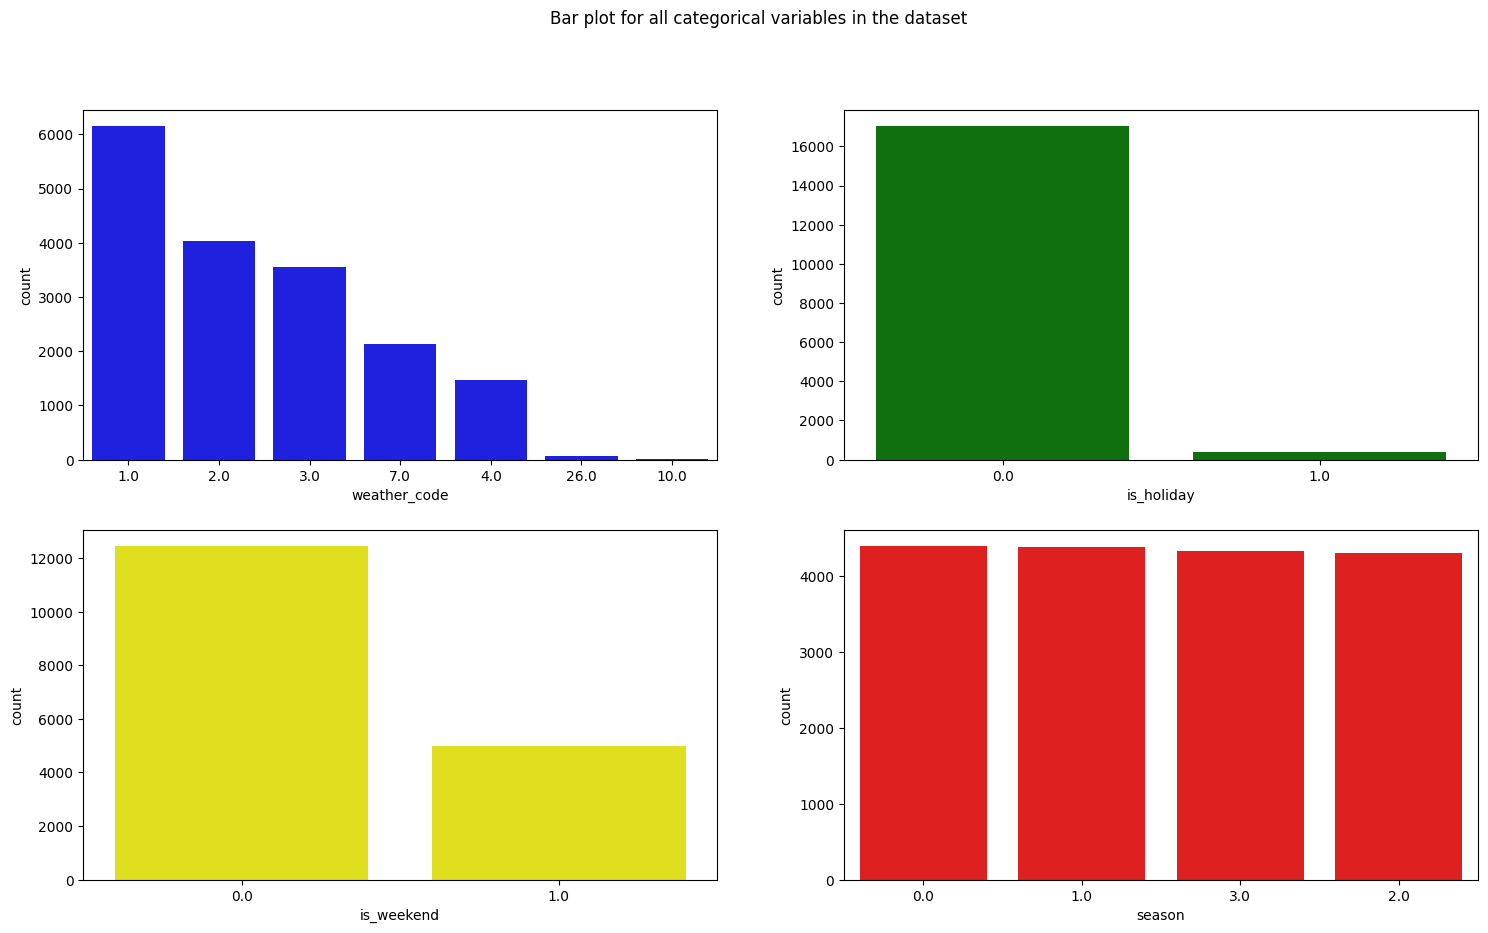

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (18, 10))
  
fig.suptitle('Bar plot for all categorical variables in the dataset')

sns.countplot(ax = axes[0, 0], x = 'weather_code', data = pdf, color = 'blue', 
              order = pdf['weather_code'].value_counts().index);

sns.countplot(ax = axes[0, 1], x = 'is_holiday', data = pdf, color = 'green', 
              order = pdf['is_holiday'].value_counts().index);

sns.countplot(ax = axes[1, 0], x = 'is_weekend', data = pdf, color = 'yellow', 
              order = pdf['is_weekend'].value_counts().index);

sns.countplot(ax = axes[1, 1], x = 'season', data = pdf, color = 'red', 
              order = pdf['season'].value_counts().index);

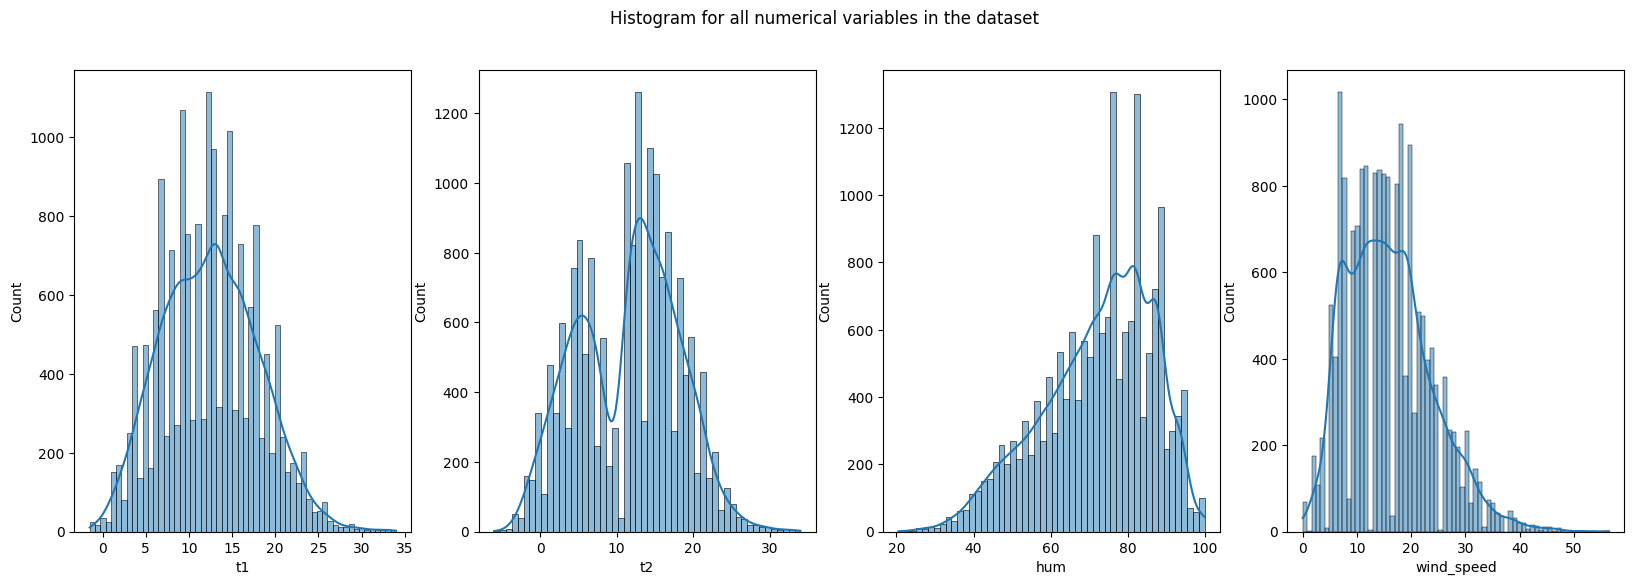

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (20, 6))
  
fig.suptitle('Histogram for all numerical variables in the dataset')
  
sns.histplot(x = 't1', data = pdf, kde = True, ax = axes[0]);

sns.histplot(x = 't2', data = pdf, kde = True, ax = axes[1]);

sns.histplot(x = 'hum', data = pdf, kde = True, ax = axes[2]);

sns.histplot(x = 'wind_speed', data = pdf, kde = True, ax = axes[3]);

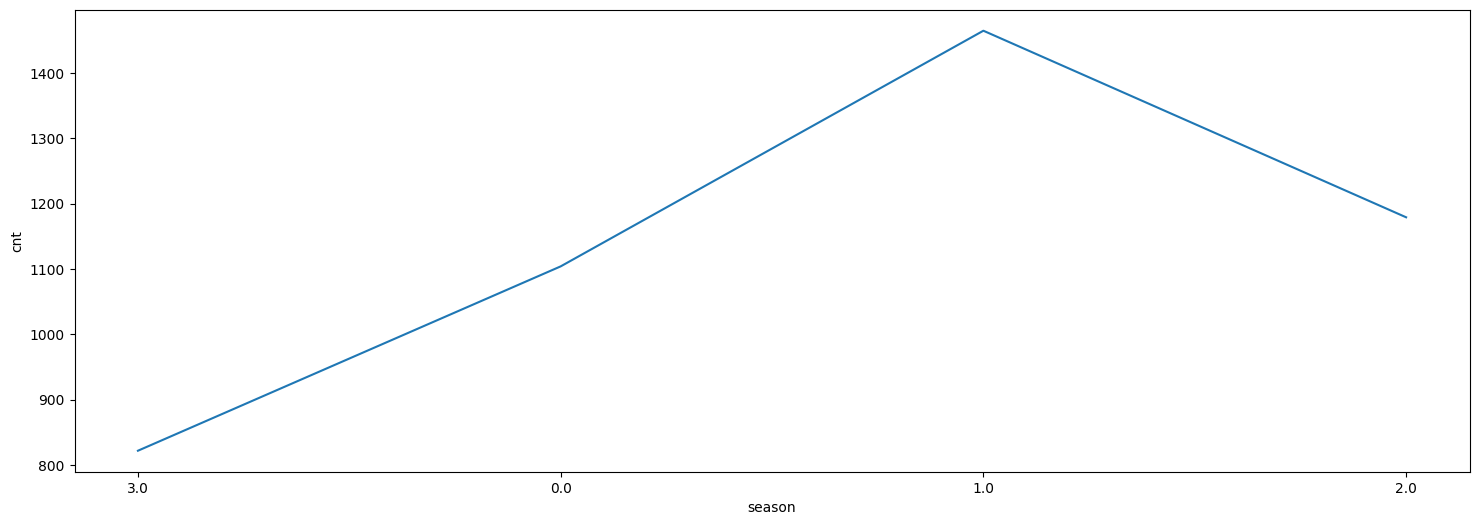

In [ ]:
fig = plt.figure(figsize = (18, 6))

sns.lineplot(x = 'season', y = 'cnt', data = pdf, ci = None, estimator = 'mean');

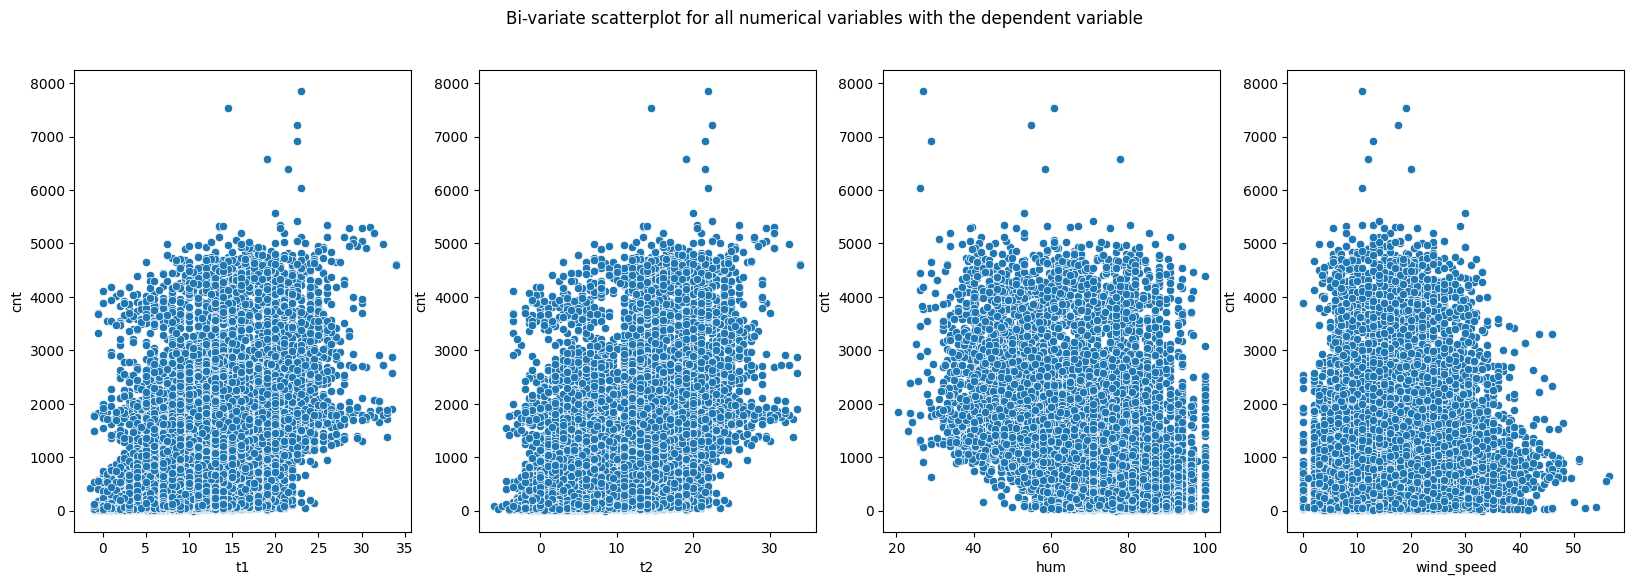

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (20, 6))
  
fig.suptitle('Bi-variate scatterplot for all numerical variables with the dependent variable')
  
sns.scatterplot(x = 't1', y = 'cnt', data = pdf, ax = axes[0]);

sns.scatterplot(x = 't2', y = 'cnt', data = pdf, ax = axes[1]);

sns.scatterplot(x = 'hum', y = 'cnt', data = pdf, ax = axes[2]);

sns.scatterplot(x = 'wind_speed', y = 'cnt', data = pdf, ax = axes[3]);


In [ ]:
pdf.isnull().sum()

timestamp       0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
cnt             0
dtype: int64

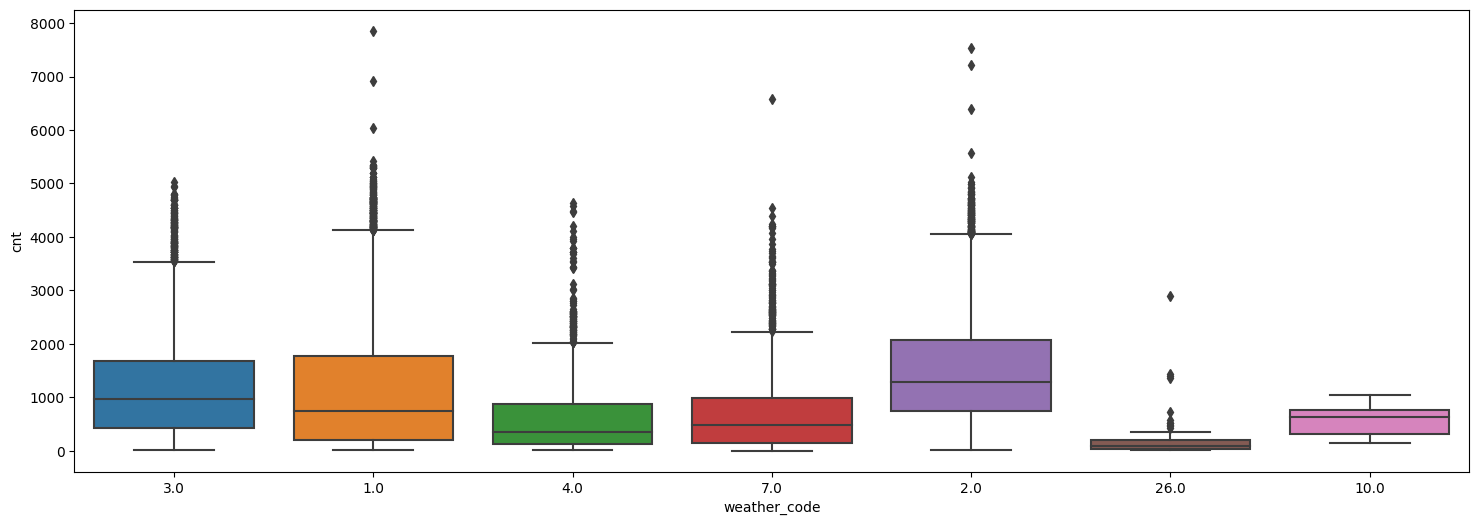

In [ ]:
fig = plt.figure(figsize = (18, 6))

sns.boxplot(x = 'weather_code', y = 'cnt', data = pdf);

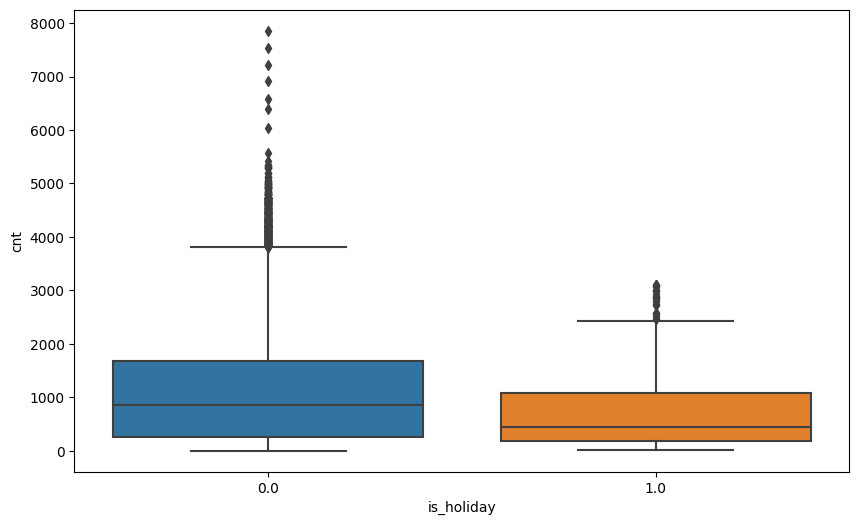

In [ ]:
fig = plt.figure(figsize = (10, 6))

sns.boxplot(x = 'is_holiday', y = 'cnt', data = pdf);

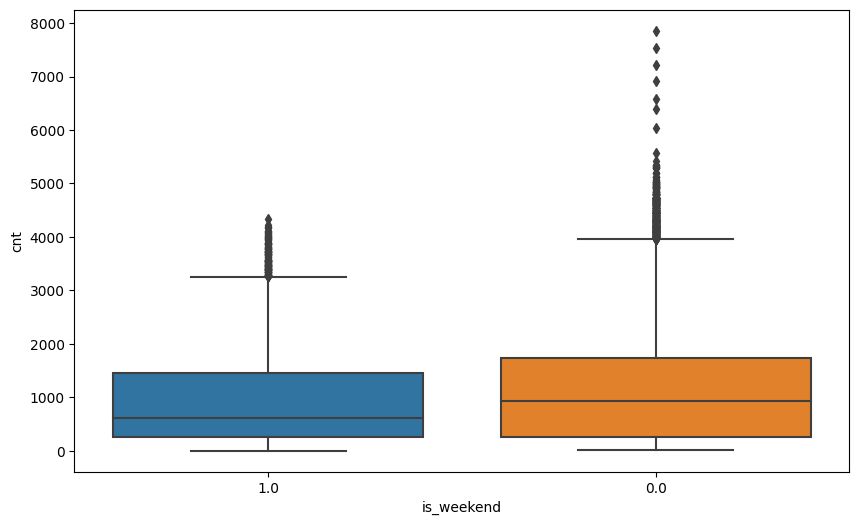

In [ ]:
fig = plt.figure(figsize = (10, 6))

sns.boxplot(x = 'is_weekend', y = 'cnt', data = pdf);

### Feature Engineering

In [ ]:
# Handling categorical and string variables
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# create object of StringIndexer class and specify input and output column
SI_weather_code = StringIndexer(inputCol='weather_code',outputCol='weather_code_Index')
SI_is_holiday = StringIndexer(inputCol='is_holiday',outputCol='is_holiday_Index')
SI_is_weekend = StringIndexer(inputCol='is_weekend',outputCol='is_weekend_Index')
SI_season = StringIndexer(inputCol='season',outputCol='season_Index')

# Handle issues
SI_weather_code.setHandleInvalid("error")
SI_is_holiday.setHandleInvalid("error")
SI_is_weekend.setHandleInvalid("error")
SI_season.setHandleInvalid("error")

# transform the data
data = SI_weather_code.fit(data).transform(data)
data = SI_is_holiday.fit(data).transform(data)
data = SI_is_weekend.fit(data).transform(data)
data = SI_season.fit(data).transform(data)


# view the transformed data
data.show(10)

+-------------------+---+----+-----+----------+------------+----------+----------+------+---+------------------+----------------+----------------+------------+
|          timestamp| t1|  t2|  hum|wind_speed|weather_code|is_holiday|is_weekend|season|cnt|weather_code_Index|is_holiday_Index|is_weekend_Index|season_Index|
+-------------------+---+----+-----+----------+------------+----------+----------+------+---+------------------+----------------+----------------+------------+
|2015-01-04 00:00:00|3.0| 2.0| 93.0|       6.0|         3.0|       0.0|       1.0|   3.0|182|               2.0|             0.0|             1.0|         2.0|
|2015-01-04 01:00:00|3.0| 2.5| 93.0|       5.0|         1.0|       0.0|       1.0|   3.0|138|               0.0|             0.0|             1.0|         2.0|
|2015-01-04 02:00:00|2.5| 2.5| 96.5|       0.0|         1.0|       0.0|       1.0|   3.0|134|               0.0|             0.0|             1.0|         2.0|
|2015-01-04 03:00:00|2.0| 2.0|100.0|    

In [ ]:
# one hot encoding the columns
# create object and specify input and output column
OHE_weather_code = OneHotEncoder(inputCols=['weather_code_Index'],outputCols=['weather_code_OHE'])
OHE_is_holiday = OneHotEncoder(inputCols=['is_holiday_Index'],outputCols=['is_holiday_OHE'])
OHE_is_weekend = OneHotEncoder(inputCols=['is_weekend_Index'],outputCols=['is_weekend_OHE'])
OHE_season = OneHotEncoder(inputCols=['season_Index'],outputCols=['season_OHE'])

# transform the data
data = OHE_weather_code.fit(data).transform(data)
data = OHE_is_holiday.fit(data).transform(data)
data = OHE_is_weekend.fit(data).transform(data)
data = OHE_season.fit(data).transform(data)



In [ ]:
data.dtypes

[('timestamp', 'timestamp'),
 ('t1', 'double'),
 ('t2', 'double'),
 ('hum', 'double'),
 ('wind_speed', 'double'),
 ('weather_code', 'string'),
 ('is_holiday', 'string'),
 ('is_weekend', 'string'),
 ('season', 'string'),
 ('cnt', 'int'),
 ('weather_code_Index', 'double'),
 ('is_holiday_Index', 'double'),
 ('is_weekend_Index', 'double'),
 ('season_Index', 'double'),
 ('weather_code_OHE', 'vector'),
 ('is_holiday_OHE', 'vector'),
 ('is_weekend_OHE', 'vector'),
 ('season_OHE', 'vector')]

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
data.columns 

['timestamp',
 't1',
 't2',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season',
 'cnt',
 'weather_code_Index',
 'is_holiday_Index',
 'is_weekend_Index',
 'season_Index',
 'weather_code_OHE',
 'is_holiday_OHE',
 'is_weekend_OHE',
 'season_OHE']

In [ ]:
assembler=VectorAssembler(inputCols=[
 't1',
 't2',
 'hum',
 'wind_speed',
  'weather_code_OHE',
 'is_holiday_OHE',
 'is_weekend_OHE',
 'season_OHE'
 ],outputCol="features")
data=assembler.transform(data)
data.select(['features','cnt']).show(5)

+--------------------+---+
|            features|cnt|
+--------------------+---+
|(15,[0,1,2,3,6,10...|182|
|(15,[0,1,2,3,4,10...|138|
|(15,[0,1,2,4,10,1...|134|
|(15,[0,1,2,4,10,1...| 72|
|(15,[0,2,3,4,10,1...| 47|
+--------------------+---+
only showing top 5 rows



In [ ]:
final_data=data.select(['features','cnt'])

In [ ]:
train_data,test_data=final_data.randomSplit([0.8,0.2])

In [ ]:
train_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- cnt: integer (nullable = true)



<b> Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol="cnt",maxIter=50)
model=lr.fit(train_data)

In [ ]:
result = model.evaluate(test_data)

In [ ]:
result.r2

0.2740178895553639

In [ ]:
result.meanAbsoluteError

674.5295175120749

In [ ]:
result.rootMeanSquaredError

913.6362866137125

In [ ]:
print("Coefficients: " + str(model.coefficients))
print("\nIntercept: " + str(model.intercept))

Coefficients: [95.64574969153674,-33.60146886431255,-27.421597042630356,-9.671655397829094,390.3115276734999,669.5491844704005,672.3699995775797,370.6600441370007,288.0687762158321,344.3862522126685,244.57995573710568,194.49723938887615,-94.22065269862283,-248.66541664470864,32.55451618176265]

Intercept: 1673.2942268943616


<b> Random FOrest regressor

In [ ]:
# Import necessary libraries
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator



# Define the Random Forest Regressor model
rf = RandomForestRegressor(numTrees=10, maxDepth=5, seed=42,labelCol="cnt")

# Train the Random Forest Regressor model
rfModel = rf.fit(train_data)

# Make predictions on the testing dataset
predictions = rfModel.transform(test_data)

# Evaluate the Random Forest Regressor model using RMSE metric
evaluator = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 905.73


<b>XGBoost Regresor

In [ ]:
# Import necessary libraries
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Define the XGBoost Regressor model
gbt = GBTRegressor(labelCol="cnt",maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, 
                   maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType="squared", maxIter=20, stepSize=0.1, seed=42)

# Train the XGBoost Regressor model
gbtModel = gbt.fit(train_data)

# Make predictions on the testing dataset
predictions = gbtModel.transform(test_data)

# Evaluate the XGBoost Regressor model using RMSE metric
evaluator = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 888.499


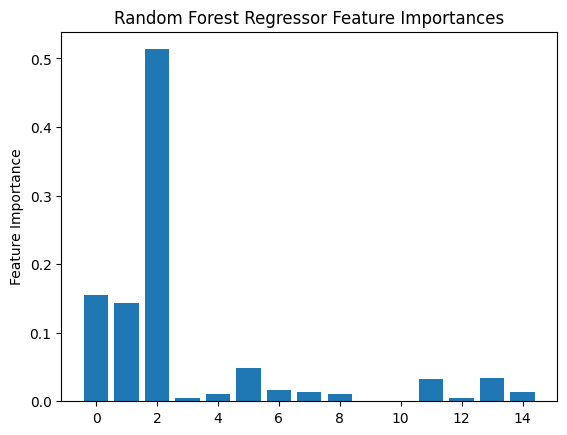

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Plot feature importances
featureImportances = rfModel.featureImportances.toArray()
x_pos = np.arange(len(featureImportances))
plt.bar(x_pos, featureImportances, align='center')
plt.ylabel('Feature Importance')
plt.title('Random Forest Regressor Feature Importances')
plt.show()




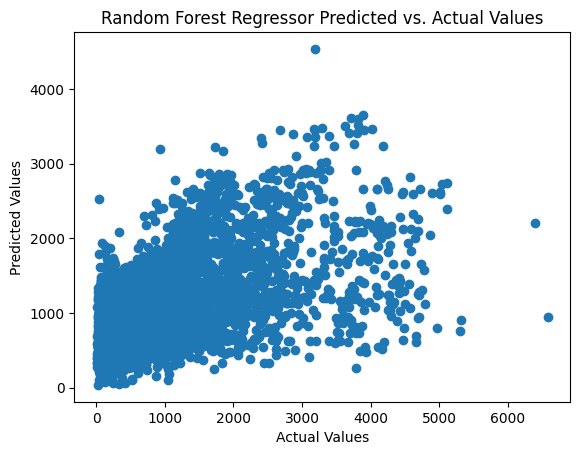

In [ ]:
# Plot predicted vs. actual values
predictions_pd = predictions.toPandas()
plt.scatter(predictions_pd.cnt, predictions_pd.prediction)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regressor Predicted vs. Actual Values')
plt.show()

In [ ]:
#  Get feature importances and sort them in descending order
featureImportances = list(rfModel.featureImportances.toArray())
sortedFeatureImportances = sorted(zip(featureImportances, data.columns[:-1]), reverse=True)

# Print feature importances in descending order
print("Feature Importances (in descending order):")
for importance, feature in sortedFeatureImportances:
    print("{}: {}".format(feature, importance))

Feature Importances (in descending order):
t2: 0.5133200995828704
timestamp: 0.1551162352481937
t1: 0.1437324258761748
weather_code: 0.048645384850686826
season_Index: 0.0340480156397658
is_holiday_Index: 0.03254128473083003
is_holiday: 0.016091484377524785
weather_code_OHE: 0.014106912424329609
is_weekend: 0.01340815460499609
wind_speed: 0.010102092309053517
season: 0.009980805906650063
is_weekend_Index: 0.004528658501719446
hum: 0.0043677599496178676
weather_code_Index: 1.068599758711567e-05
cnt: 0.0


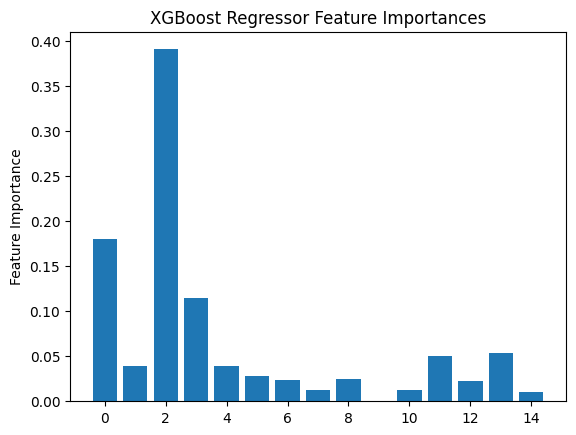

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot feature importances
featureImportances = gbtModel.featureImportances.toArray()
x_pos = np.arange(len(featureImportances))
plt.bar(x_pos, featureImportances, align='center')

plt.ylabel('Feature Importance')
plt.title('XGBoost Regressor Feature Importances')
plt.show()




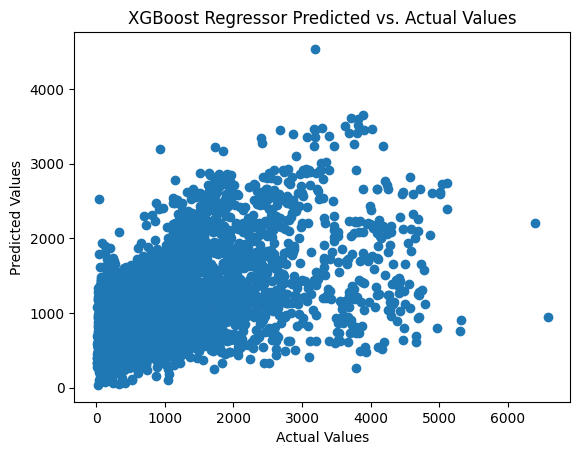

In [ ]:

# Plot predicted vs. actual values
predictions_pd = predictions.toPandas()
plt.scatter(predictions_pd.cnt, predictions_pd.prediction)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regressor Predicted vs. Actual Values')
plt.show()
